<a href="https://colab.research.google.com/github/eswistak88/DataMiningProject/blob/sabiya/Ensembles_CNN_LSTM%20with%20Soft%20Voting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [52]:
import os
import re
import glob
import struct
from os import makedirs

import numpy as np
from numpy import asarray
from numpy import zeros
from nltk.stem.porter import *


import pandas as pd
import tensorflow as tf
import tensorflow.keras as keras

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras import Model
from keras.callbacks import ModelCheckpoint
from keras.callbacks import EarlyStopping
from keras.wrappers.scikit_learn import KerasClassifier
from keras.models import Sequential
from keras.layers import Input, Reshape, Conv2D, MaxPool2D, Dense, Dropout, Flatten, Embedding, Concatenate, Conv1D
from keras.metrics import CategoricalAccuracy, Precision, Recall
from keras import regularizers
from keras import backend as K
from keras.models import load_model

import sklearn
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.ensemble import StackingClassifier

import matplotlib.pyplot as plt


Load the Dataset


In [53]:

def create_data_corpus(path):
  files = glob.glob(path + "/*.csv")
  df_list = []
  
  for file in files:
    df = pd.read_csv(file, index_col=None, header=0, engine='python')
    df_list.append(df)

  frame = pd.concat(df_list, axis=0, ignore_index=True)
  return frame

In [54]:
names = ['TweetID', 'Sentiment', 'Tweet']

train = create_data_corpus('/content/drive/MyDrive/twit/train/MegaData')

train.head()

,Column1,Column2,Column3
0,4.343150e+17,negative,@MetroNorth wall to wall people on the platfor...
1,4.376050e+17,neutral,ang sarap mging panganay. Pag ikaw may kylngan...
2,4.374240e+17,negative,RT @katie_rohaley: School on Monday is just go...
3,4.368360e+17,negative,Thanks manager for putting me on the schedule ...
4,4.356710e+17,negative,Who needs sleep? It's not like I have a test t...


Data Preprocessing

In [59]:
def remove_pattern(input_txt, pattern):
  r = re.findall(pattern, input_txt)
  for i in r:
    input_txt = re.sub(i, '', input_txt)        
  return input_txt


def clean_tweets(frame, column_name, remove_stop_words=True, lower_case=True, remove_special=True):
  frame = frame.drop_duplicates().reset_index(drop=True) #remove duplicate rows
  frame['Tweet_Clean_Text'] = np.vectorize(remove_pattern)(frame[column_name], "RT @[\w]*:") #remove twitter return handle
  frame.Tweet_Clean_Text = np.vectorize(remove_pattern)(frame['Tweet_Clean_Text'], "@[\w]*") #remove twitter handle
  frame.Tweet_Clean_Text = np.vectorize(remove_pattern)(frame['Tweet_Clean_Text'], "https?://[A-Za-z0-9./]*") #remove URLs

  if remove_special:
    frame.Tweet_Clean_Text = frame.Tweet_Clean_Text.str.replace("[^a-zA-Z#]", " ") #remove special characters except for #
  frame.Tweet_Clean_Text = frame.Tweet_Clean_Text.replace('\s+', ' ', regex=True) #remove extra spaces in between words
  if lower_case:
    frame.Tweet_Clean_Text = frame.Tweet_Clean_Text.apply(lambda x: x.lower())
  if remove_stop_words:
    frame.Tweet_Clean_Text = frame.Tweet_Clean_Text.apply(lambda x: ' '.join([word for word in x.split() if word not in stopwords.words('english')])) #remove stop words

  return frame

In [60]:
train_set = clean_tweets(train, 'Column3',remove_stop_words=False, remove_special=False)
train_set.head()

,Column1,Column2,Column3,Tweet_Clean_Text
0,4.343150e+17,negative,@MetroNorth wall to wall people on the platfor...,wall to wall people on the platform at south ...
1,4.376050e+17,neutral,ang sarap mging panganay. Pag ikaw may kylngan...,ang sarap mging panganay. pag ikaw may kylngan...
2,4.374240e+17,negative,RT @katie_rohaley: School on Monday is just go...,school on monday is just gonna be a great time
3,4.368360e+17,negative,Thanks manager for putting me on the schedule ...,thanks manager for putting me on the schedule ...
4,4.356710e+17,negative,Who needs sleep? It's not like I have a test t...,who needs sleep? it's not like i have a test t...


In [62]:
train_set["Sentiment_Value"] = train_set["Column2"].map({"neutral": 0, "positive": 1, "negative": 2})
label = to_categorical(train_set["Sentiment_Value"], 3)
train_set

,Column1,Column2,Column3,Tweet_Clean_Text,Sentiment_Value
0,4.343150e+17,negative,@MetroNorth wall to wall people on the platfor...,wall to wall people on the platform at south ...,2
1,4.376050e+17,neutral,ang sarap mging panganay. Pag ikaw may kylngan...,ang sarap mging panganay. pag ikaw may kylngan...,0
2,4.374240e+17,negative,RT @katie_rohaley: School on Monday is just go...,school on monday is just gonna be a great time,2
3,4.368360e+17,negative,Thanks manager for putting me on the schedule ...,thanks manager for putting me on the schedule ...,2
4,4.356710e+17,negative,Who needs sleep? It's not like I have a test t...,who needs sleep? it's not like i have a test t...,2
...,...,...,...,...,...
114213,6.390170e+17,neutral,@YouAreMyArsenal Wouldn't surprise me if we en...,wouldn't surprise me if we enquired.he can't ...,0
114214,6.402770e+17,neutral,Rib injury for Zlatan against Russia is a big ...,rib injury for zlatan against russia is a big ...,0
114215,6.402970e+17,neutral,Noooooo! I was hoping to see Zlatan being Zlat...,noooooo! i was hoping to see zlatan being zlat...,0
114216,6.410170e+17,neutral,@Fronsoir Zlatan has never done it on a wet Tu...,zlatan has never done it on a wet tuesday nig...,0


In [63]:
y_labels = train_set['Sentiment_Value']
y_labels.shape

(114218,)

In [64]:
tweet_set['l'] = train_set['Tweet_Clean_Text'].apply(lambda x: len(str(x).split(' ')))
print("mean length of sentence: " + str(tweet_set.l.mean()))
print("max length of sentence: " + str(tweet_set.l.max()))
print("std dev length of sentence: " + str(tweet_set.l.std()))

mean length of sentence: 16.71109632457231
max length of sentence: 40.0
std dev length of sentence: 6.599111305083554


In [65]:
sequence_length = 52 #using the maximum length 

In [66]:
max_features = 2500
tokenizer = Tokenizer(num_words=max_features, split=' ', oov_token='<unw>')
tokenizer.fit_on_texts(train_set['Tweet_Clean_Text'].values)

X = tokenizer.texts_to_sequences(train_set['Tweet_Clean_Text'].values)
X = pad_sequences(X, sequence_length)
x_train = X

print("training size " + str(len(x_train)))

voc_size = len(tokenizer.word_index) + 1
print("Vocab size: ", voc_size)
print("Input shape: ", x_train.shape)
print("Y_shape: " , y_labels.shape)

training size 114218
Vocab size:  73457
Input shape:  (114218, 52)
Y_shape:  (114218,)


Spliting the dataset

In [293]:
X_train, X_dev, Y_train, Y_dev = train_test_split(x_train, y_labels, test_size=0.15, shuffle=True, random_state=10)

GloVe Embedding

In [68]:
embeddings_index = dict()
f = open('/content/drive/MyDrive/glove.twitter.27B/glove.twitter.27B.200d.txt')
for line in f:
	values = line.split()
	word = values[0]
	coefs = asarray(values[1:], dtype='float32')
	embeddings_index[word] = coefs
f.close()
print('Loaded %s word vectors.' % len(embeddings_index))

Loaded 1193514 word vectors.


In [69]:
embedding_dim = 200
embedding_matrix = np.zeros((voc_size, embedding_dim))
for word, i in tokenizer.word_index.items():
	embedding_vector = embeddings_index.get(word)
	if embedding_vector is not None:
		embedding_matrix[i] = embedding_vector

METRICS

In [70]:
import seaborn as sns
from sklearn import metrics

THRESHOLD = 0.35

class EpochMetricsCallback(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.f1s = []
        self.precisions = []
        self.recalls = []
        
    def on_epoch_end(self, epoch, logs={}):
        predictions = self.model.predict(self.validation_data[0])
        predictions = (predictions > THRESHOLD).astype(int)
        predictions = np.asarray(predictions)
        targets = self.validation_data[1]
        f1 = metrics.f1_score(targets, predictions)
        precision = metrics.precision_score(targets, predictions)
        recall = metrics.recall_score(targets, predictions)

        print(" - F1 score: {0:.4f}, Precision: {1:.4f}, Recall: {2:.4f}"
              .format(f1, precision, recall))
        self.f1s.append(f1)
        self.precisions.append(precision)
        self.recalls.append(recall)
        return
    
def display_model_history(history):
    data = pd.DataFrame(data={'Train': history.history['loss'], 'Test': history.history['val_loss']})
    ax = sns.lineplot(data=data, palette="pastel", linewidth=2.5, dashes=False)
    ax.set(xlabel='Epoch', ylabel='Loss', title='Loss')
    plt.show()

def display_model_epoch_metrics(epoch_callback):
    fig, axes = plt.subplots(1, 3, figsize = (15, 5), sharey=False)
    a1, a2, a3 = axes
    
    a1.set_title('F1')
    a1.set(xlabel='Epoch', title='F1')
    sns.lineplot(data=pd.DataFrame(data={'F1': epoch_callback.f1s}),
                 palette="pastel", linewidth=2.5, dashes=False, ax=a1, legend=False)

    a2.set_title('Precision')
    a2.set(xlabel='Epoch', title='Precision')
    sns.lineplot(data=pd.DataFrame(data={'Precision': epoch_callback.precisions}),
                 palette="pastel", linewidth=2.5, dashes=False, ax=a2, legend=False)

    a3.set_title('Recall')
    a3.set(xlabel='Epoch', title='Recall')
    sns.lineplot(data=pd.DataFrame(data={'Recall': epoch_callback.recalls}),
                 palette="pastel", linewidth=2.5, dashes=False, ax=a3, legend=False)

    plt.show()

In [71]:
Y_train_cat = to_categorical(Y_train, 3)
Y_dev_cat = to_categorical(Y_dev, 3)

In [337]:
def recall_score(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    recall_score.__name__ = 'recall'
    return recall

def precision_score(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    precision_score.__name__ = 'precision'
    return precision

def f1_metrics(y_true, y_pred):
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1_metrics.__name__ = 'f1'
    return 2*((precision*recall)/(precision+recall+K.epsilon()))


In [338]:
Metrics = [
           keras.metrics.CategoricalAccuracy(name = 'categorical_accuracy'),
           keras.metrics.Precision(name='precision'),
           keras.metrics.Recall(name='recall'),
           f1_metrics
]

In [339]:
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
plt.rcParams['figure.figsize'] = 15, 10

In [340]:
def plot_metrics(history):
  metrics = ['loss', 'categorical_accuracy', 'precision', 'recall', 'f1_metrics']
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(2,3,n+1)
    plt.plot(history.epoch, history.history[metric], color=colors[0], label='Train')
    plt.plot(history.epoch, history.history['val_'+metric],
             color=colors[0], linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    else:
      plt.ylim([0,1])

    plt.legend()

**Stacked CNN Predictions Ensemble**

In [76]:
def cnn_1(filter_size):
  model = Sequential()
  model.add(keras.layers.Input(shape=(sequence_length, ), dtype='int32'))
  model.add(Embedding(input_dim=voc_size, output_dim=embedding_dim, weights = [embedding_matrix],input_length=sequence_length))
  model.add(Reshape((sequence_length, embedding_dim, 1)))
  model.add(Conv2D(1024, kernel_size=(filter_size, embedding_dim), activation='relu', kernel_regularizer=regularizers.l2(3)))
  model.add(MaxPool2D(pool_size=(sequence_length - filter_size + 1, 1), strides=(1,1), padding='valid'))
  model.add(Flatten())
  model.add(Dropout(0.5))
  model.add(Dense(units=352, activation='relu'))
  model.add(Dense(units=3, activation='softmax'))
  model.summary()
  filepath = "/content/drive/MyDrive/Colab Notebooks/cnn_model_1.h5"
  checkpoint = ModelCheckpoint(filepath=filepath, monitor="val_f1_metrics",mode="max",save_best_only = True,verbose=2)
  earlystop = EarlyStopping(monitor = 'val_loss',min_delta = 0, patience = 10, verbose = 1, restore_best_weights = True)
  callbacks = [earlystop,checkpoint] 
  model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=Metrics)
  cnn_history = model.fit(x=X_train, y=Y_train_cat, validation_data=(X_dev, Y_dev_cat), batch_size=1028, epochs=20, callbacks=callbacks,verbose=2, shuffle=True)
  plot_metrics(cnn_history)
  return model

In [77]:
train_predictions = []
test_predictions = []

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 52, 200)           14691400  
_________________________________________________________________
reshape_1 (Reshape)          (None, 52, 200, 1)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 42, 1, 1024)       2253824   
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 1, 1, 1024)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 1024)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 352)              

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


95/95 - 8s
17/17 - 1s


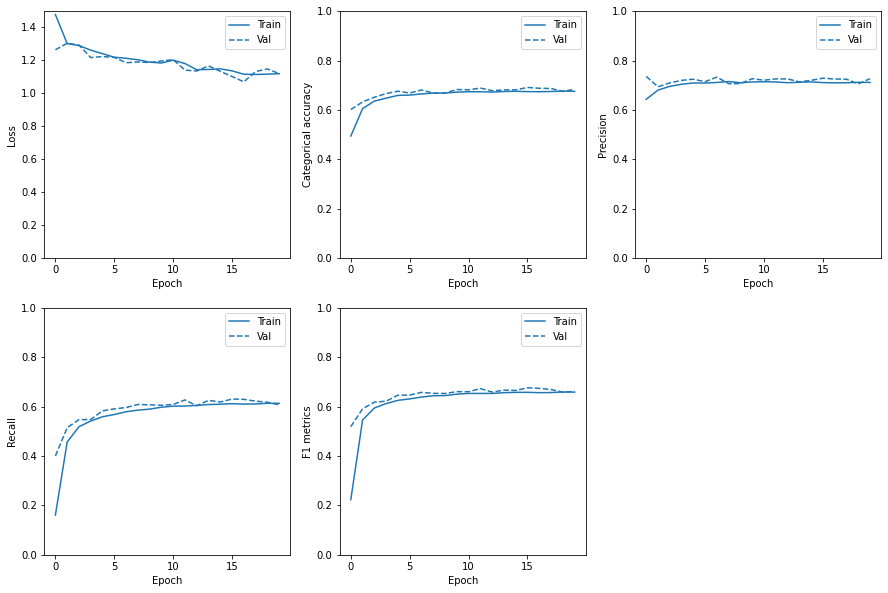

In [78]:
cnn_1 = cnn_1(11)
train_predictions.append(cnn_1.predict_classes([X_train], batch_size=1024, verbose=2))
test_predictions.append(cnn_1.predict_classes([X_dev], batch_size=1024, verbose=2))

In [83]:
def cnn_2(filter_size):
  model_2 = Sequential()
  model_2.add(keras.layers.Input(shape=(sequence_length, ), dtype='int32'))
  model_2.add(Embedding(input_dim=voc_size, output_dim=embedding_dim, weights = [embedding_matrix],input_length=sequence_length))
  model_2.add(Reshape((sequence_length, embedding_dim, 1)))
  model_2.add(Conv2D(1224, kernel_size=(filter_size, embedding_dim), activation='relu', kernel_regularizer=regularizers.l2(3)))
  model_2.add(MaxPool2D(pool_size=(sequence_length - filter_size + 1, 1), strides=(1,1), padding='valid'))
  model_2.add(Flatten())
  model_2.add(Dropout(0.5))
  model_2.add(Dense(units=352, activation='relu'))
  model_2.add(Dense(units=3, activation='softmax'))
  model_2.summary()

  filepath = "/content/drive/MyDrive/Colab Notebooks/cnn_model_2.h5"
  checkpoint = ModelCheckpoint(filepath=filepath, monitor="val_f1_metrics",mode="max",save_best_only = True,verbose=2)
  earlystop = EarlyStopping(monitor = 'val_loss',min_delta = 0, patience = 10, verbose = 1, restore_best_weights = True)
  callbacks = [earlystop,checkpoint] 

  model_2.compile(loss='categorical_crossentropy', optimizer='adam', metrics=Metrics)
  cnn_history_2 = model_2.fit(x=X_train, y=Y_train_cat, validation_data=(X_dev, Y_dev_cat), batch_size=1028, epochs=20, callbacks=callbacks,verbose=2, shuffle=True)
  plot_metrics(cnn_history_2)
  return model_2

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 52, 200)           14691400  
_________________________________________________________________
reshape_2 (Reshape)          (None, 52, 200, 1)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 44, 1, 1224)       2204424   
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 1, 1, 1224)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 1224)              0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 1224)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 352)              

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


95/95 - 8s
17/17 - 2s


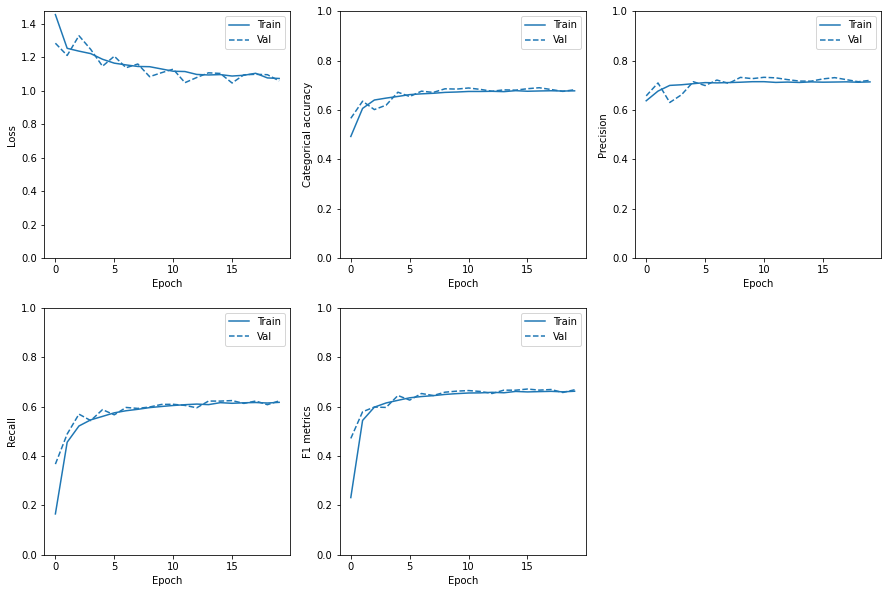

In [84]:
cnn_2 = cnn_2(9)
train_predictions.append(cnn_2.predict_classes([X_train], batch_size=1024, verbose=2))
test_predictions.append(cnn_2.predict_classes([X_dev], batch_size=1024, verbose=2))

In [89]:
def cnn_3(filter_size):
  model_3 = Sequential()
  model_3.add(keras.layers.Input(shape=(sequence_length, ), dtype='int32'))
  model_3.add(Embedding(input_dim=voc_size, output_dim=embedding_dim, weights = [embedding_matrix],input_length=sequence_length))
  model_3.add(Reshape((sequence_length, embedding_dim, 1)))
  model_3.add(Conv2D(1024, kernel_size=(filter_size, embedding_dim), activation='relu', kernel_regularizer=regularizers.l2(3)))
  model_3.add(MaxPool2D(pool_size=(sequence_length - filter_size + 1, 1), strides=(1,1), padding='valid'))
  model_3.add(Flatten())
  model_3.add(Dropout(0.5))
  model_3.add(Dense(units=352, activation='relu'))
  model_3.add(Dense(units=3, activation='softmax'))
  model_3.summary()

  filepath = "/content/drive/MyDrive/Colab Notebooks/cnn_model_3.h5"
  checkpoint = ModelCheckpoint(filepath=filepath, monitor="val_f1_metrics",mode="max",save_best_only = True,verbose=2)
  earlystop = EarlyStopping(monitor = 'val_loss',min_delta = 0, patience = 10, verbose = 1, restore_best_weights = True)
  callbacks = [earlystop,checkpoint] 

  model_3.compile(loss='categorical_crossentropy', optimizer='adam', metrics=Metrics)
  cnn_history_3 = model_3.fit(x=X_train, y=Y_train_cat, validation_data=(X_dev, Y_dev_cat), batch_size=1028, epochs=20, callbacks=callbacks,verbose=2, shuffle=True)
  plot_metrics(cnn_history_3)
  return model_3

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 52, 200)           14691400  
_________________________________________________________________
reshape_3 (Reshape)          (None, 52, 200, 1)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 44, 1, 1024)       1844224   
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 1, 1, 1024)        0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 1024)              0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 352)              

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


95/95 - 7s
17/17 - 1s


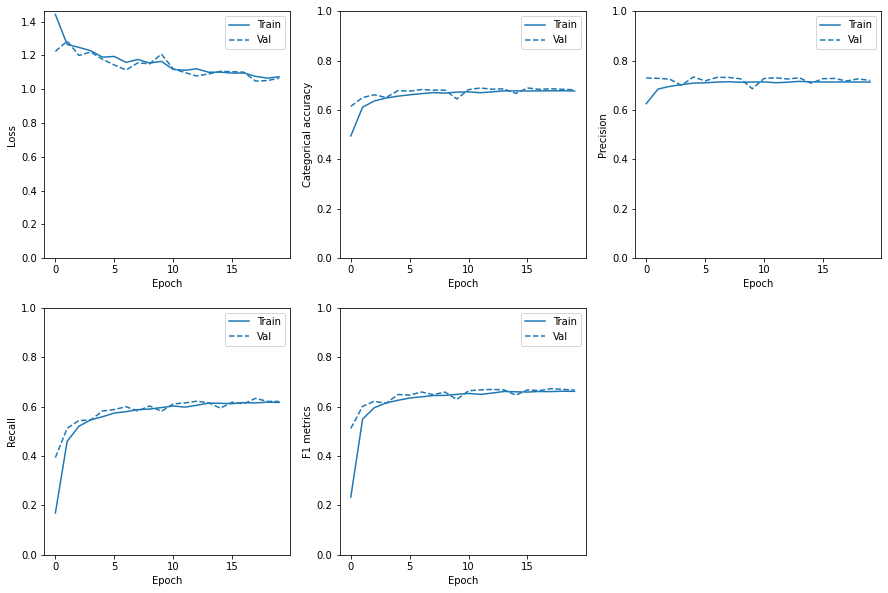

In [90]:
cnn_3 = cnn_3(9)
train_predictions.append(cnn_3.predict_classes([X_train], batch_size=1024, verbose=2))
test_predictions.append(cnn_3.predict_classes([X_dev], batch_size=1024, verbose=2))

In [95]:
def cnn_4(filter_size):
  model_4 = Sequential()
  model_4.add(keras.layers.Input(shape=(sequence_length, ), dtype='int32'))
  model_4.add(Embedding(input_dim=voc_size, output_dim=embedding_dim, weights = [embedding_matrix],input_length=sequence_length))
  model_4.add(Reshape((sequence_length, embedding_dim, 1)))
  model_4.add(Conv2D(1028, kernel_size=(filter_size, embedding_dim), activation='relu', kernel_regularizer=regularizers.l2(3)))
  model_4.add(MaxPool2D(pool_size=(sequence_length - filter_size + 1, 1), strides=(1,1), padding='valid'))
  model_4.add(Flatten())
  model_4.add(Dropout(0.5))
  model_4.add(Dense(units=352, activation='relu'))
  model_4.add(Dense(units=3, activation='softmax'))
  model_4.summary()

  filepath = "/content/drive/MyDrive/Colab Notebooks/cnn_model_4.h5"
  checkpoint = ModelCheckpoint(filepath=filepath, monitor="val_f1_metrics",mode="max",save_best_only = True,verbose=2)
  earlystop = EarlyStopping(monitor = 'val_loss',min_delta = 0, patience = 10, verbose = 1, restore_best_weights = True)
  callbacks = [earlystop,checkpoint] 

  model_4.compile(loss='categorical_crossentropy', optimizer='adam', metrics=Metrics)
  cnn_history_4 = model_4.fit(x=X_train, y=Y_train_cat, validation_data=(X_dev, Y_dev_cat), batch_size=1028, epochs=20, callbacks=callbacks,verbose=2, shuffle=True)
  plot_metrics(cnn_history_4)
  return model_4

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 52, 200)           14691400  
_________________________________________________________________
reshape_4 (Reshape)          (None, 52, 200, 1)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 48, 1, 1028)       1029028   
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 1, 1, 1028)        0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 1028)              0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 1028)              0         
_________________________________________________________________
dense_8 (Dense)              (None, 352)              

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


95/95 - 5s
17/17 - 1s


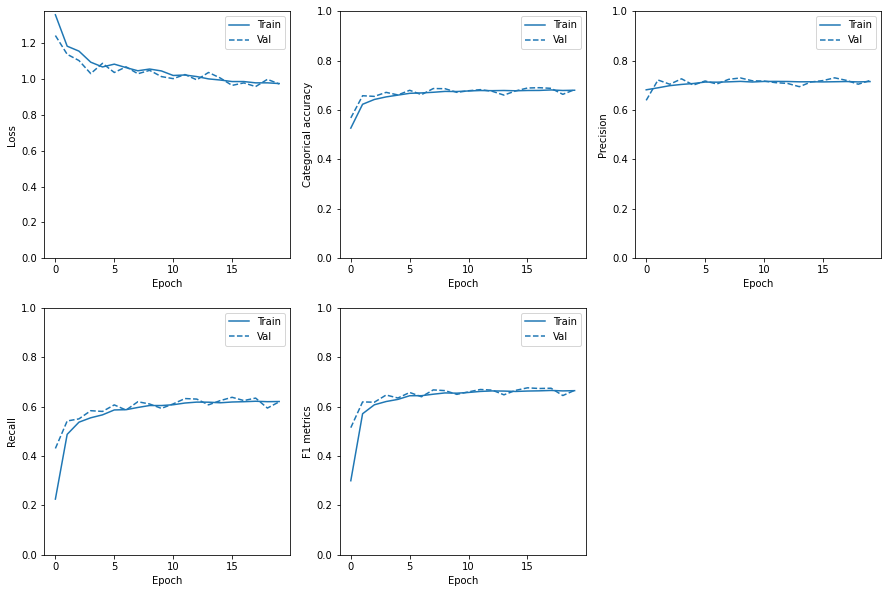

In [96]:
cnn_4 = cnn_4(5)
train_predictions.append(cnn_4.predict_classes([X_train], batch_size=1024, verbose=2))
test_predictions.append(cnn_4.predict_classes([X_dev], batch_size=1024, verbose=2))

In [101]:
def cnn_5(filter_size):
  model_5 = Sequential()
  model_5.add(keras.layers.Input(shape=(sequence_length, ), dtype='int32'))
  model_5.add(Embedding(input_dim=voc_size, output_dim=embedding_dim, weights = [embedding_matrix],input_length=sequence_length))
  model_5.add(Reshape((sequence_length, embedding_dim, 1)))
  model_5.add(Conv2D(1028, kernel_size=(filter_size, embedding_dim), activation='relu', kernel_regularizer=regularizers.l2(3)))
  model_5.add(MaxPool2D(pool_size=(sequence_length - filter_size + 1, 1), strides=(1,1), padding='valid'))
  model_5.add(Flatten())
  model_5.add(Dropout(0.75))
  model_5.add(Dense(units=352, activation='relu'))
  model_5.add(Dense(units=3, activation='softmax'))
  model_5.summary()

  filepath = "/content/drive/MyDrive/Colab Notebooks/cnn_model_5.h5"
  checkpoint = ModelCheckpoint(filepath=filepath, monitor="val_f1_metrics",mode="max",save_best_only = True,verbose=2)
  earlystop = EarlyStopping(monitor = 'val_loss',min_delta = 0, patience = 10, verbose = 1, restore_best_weights = True)
  callbacks = [earlystop,checkpoint] 

  model_5.compile(loss='categorical_crossentropy', optimizer='adam', metrics=Metrics)
  cnn_history_5 = model_5.fit(x=X_train, y=Y_train_cat, validation_data=(X_dev, Y_dev_cat), batch_size=1028, epochs=20, callbacks=callbacks,verbose=2, shuffle=True)
  plot_metrics(cnn_history_5)
  return model_5

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 52, 200)           14691400  
_________________________________________________________________
reshape_5 (Reshape)          (None, 52, 200, 1)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 50, 1, 1028)       617828    
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 1, 1, 1028)        0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 1028)              0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 1028)              0         
_________________________________________________________________
dense_10 (Dense)             (None, 352)              

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


95/95 - 4s
17/17 - 1s


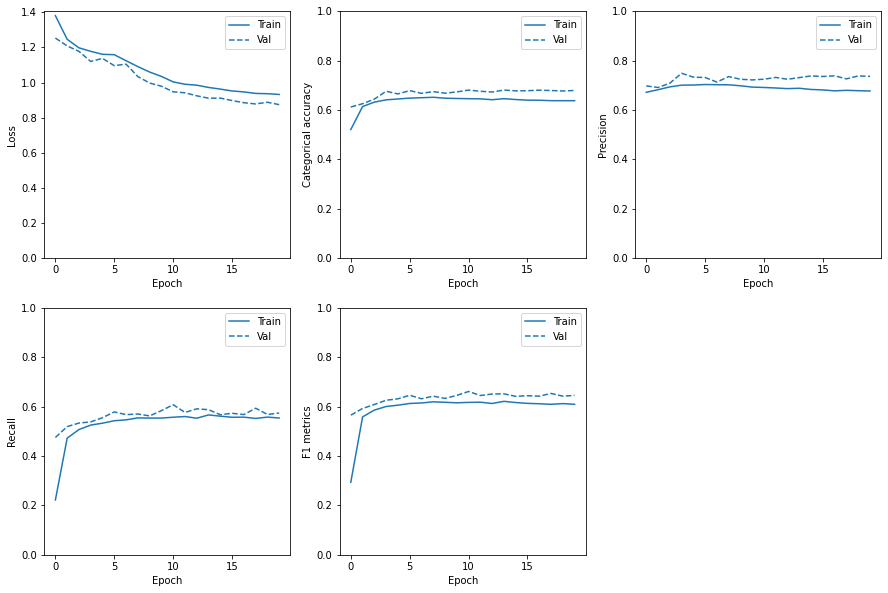

In [102]:
cnn_5 = cnn_5(3)
train_predictions.append(cnn_5.predict_classes([X_train], batch_size=1024, verbose=2))
test_predictions.append(cnn_5.predict_classes([X_dev], batch_size=1024, verbose=2))

In [342]:
r = np.array(list(zip(*np.squeeze(test_predictions))))
r.shape

(17133, 5)

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        [(None, 5)]               0         
_________________________________________________________________
dropout_24 (Dropout)         (None, 5)                 0         
_________________________________________________________________
dense_36 (Dense)             (None, 3125)              18750     
_________________________________________________________________
dropout_25 (Dropout)         (None, 3125)              0         
_________________________________________________________________
dense_37 (Dense)             (None, 200)               625200    
_________________________________________________________________
batch_normalization_4 (Batch (None, 200)               800       
_________________________________________________________________
dropout_26 (Dropout)         (None, 200)               0   

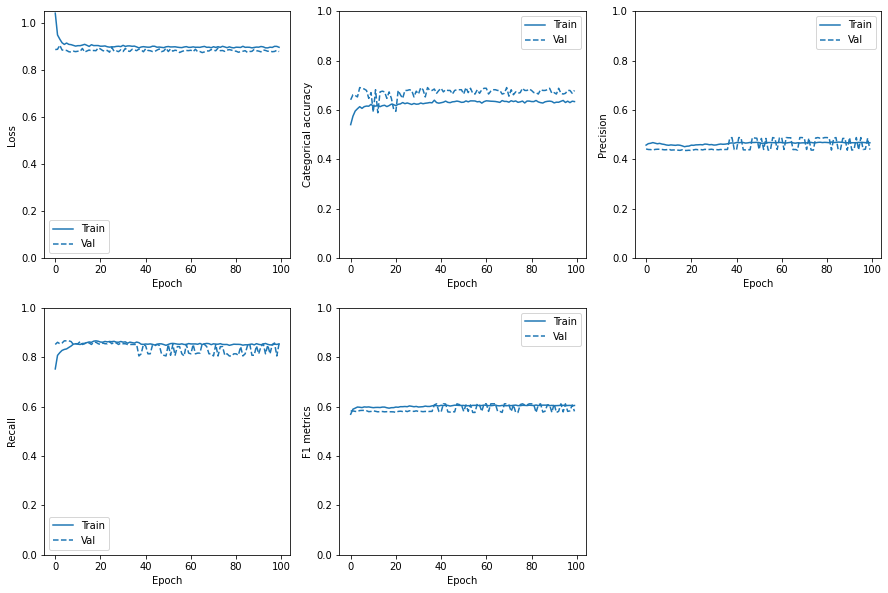

In [164]:
from keras.layers import BatchNormalization
def stack_models(predictions, targets):
    layer_size = len(predictions)
    inp = Input(shape=(layer_size,))
    d0 = Dropout(0.2)(inp)
    d0 = Dense(pow(layer_size, 5))(d0)
    d1 = Dropout(0.2)(d0)
    d1 = Dense(40 * layer_size)(d1)
    b = BatchNormalization()(d1)
    out = Dropout(0.2)(b)
    out = Dense(3, activation='sigmoid')(out)

    cnn_models = Model(inputs=inp, outputs=out)
    cnn_models.compile(loss='categorical_crossentropy', optimizer='adam', metrics=Metrics)
    cnn_models.summary()

    x = np.array(list(zip(*np.squeeze(predictions))))
    y = targets
    print(np.shape(x))
    print(np.shape(y))
    filepath = "/content/drive/MyDrive/Colab Notebooks/stacked_cnn_models.h5"
    checkpoint = ModelCheckpoint(filepath=filepath, monitor="val_f1_metrics",mode="max",save_best_only = True,verbose=2)
    earlystop = EarlyStopping(monitor = 'val_loss',min_delta = 0, patience = 10, verbose = 1, restore_best_weights = True)
    callbacks = [checkpoint] 
   
    
    all_cnn_history = cnn_models.fit(x=x, y=y, epochs=100, validation_split=0.02, callbacks=callbacks,verbose=2) 
    plot_metrics(all_cnn_history)
    return cnn_models
    
stacked_cnn_model = stack_models(test_predictions, Y_dev_cat)

stacked_test_predictions = np.array(list(zip(*np.squeeze(test_predictions))))
stacked_test_predictions = stacked_cnn_model.predict(stacked_test_predictions, batch_size=1024)

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_13 (InputLayer)        [(None, 5)]               0         
_________________________________________________________________
dropout_30 (Dropout)         (None, 5)                 0         
_________________________________________________________________
dense_42 (Dense)             (None, 3125)              18750     
_________________________________________________________________
dropout_31 (Dropout)         (None, 3125)              0         
_________________________________________________________________
dense_43 (Dense)             (None, 200)               625200    
_________________________________________________________________
batch_normalization_6 (Batch (None, 200)               800       
_________________________________________________________________
dropout_32 (Dropout)         (None, 200)               0   

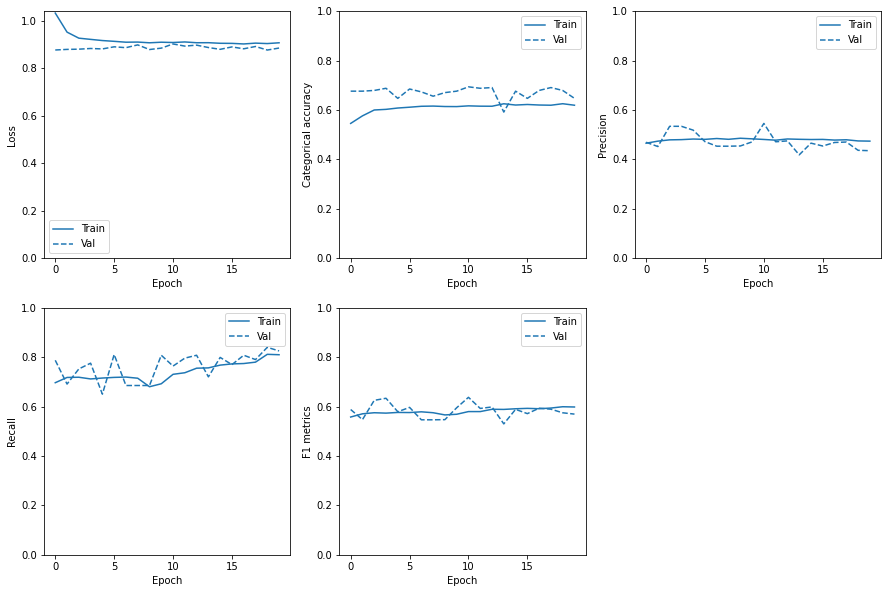

In [341]:
from keras.layers import BatchNormalization
def stack_models(predictions, targets):
    layer_size = len(predictions)
    inp = Input(shape=(layer_size,))
    d0 = Dropout(0.2)(inp)
    d0 = Dense(pow(layer_size, 5))(d0)
    d1 = Dropout(0.2)(d0)
    d1 = Dense(40 * layer_size)(d1)
    b = BatchNormalization()(d1)
    out = Dropout(0.2)(b)
    out = Dense(3, activation='sigmoid')(out)

    cnn_models = Model(inputs=inp, outputs=out)
    cnn_models.compile(loss='categorical_crossentropy', optimizer='adam', metrics=Metrics)
    cnn_models.summary()

    x = np.array(list(zip(*np.squeeze(predictions))))
    y = targets
    print(np.shape(x))
    print(np.shape(y))
    #filepath = "/content/drive/MyDrive/Colab Notebooks/stacked_cnn_models.h5"
    #checkpoint = ModelCheckpoint(filepath=filepath, monitor="val_f1_metrics",mode="max",save_best_only = True,verbose=2)
    earlystop = EarlyStopping(monitor = 'val_loss',min_delta = 0, patience = 10, verbose = 1, restore_best_weights = True)
    #callbacks = [checkpoint] 
   
    
    all_cnn_history = cnn_models.fit(x=x, y=y, epochs=20, validation_split=0.02,verbose=2) 
    plot_metrics(all_cnn_history)
    return cnn_models
    
stacked_cnn_model = stack_models(test_predictions, Y_dev_cat)

stacked_test_predictions = np.array(list(zip(*np.squeeze(test_predictions))))
stacked_test_predictions = stacked_cnn_model.predict(stacked_test_predictions, batch_size=1024)

**Weighted Average Ensemble - Grid Search**

In [ ]:

from sklearn.datasets import make_blobs
from sklearn.metrics import accuracy_score
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense
from matplotlib import pyplot
from numpy import mean
from numpy import std
from numpy import array
from numpy import argmax
from numpy import tensordot
from numpy.linalg import norm
from itertools import product



In [ ]:
def fit_model(filter_size, X_train, Y_train_cat):
  inputs = Input(shape=(sequence_length,), dtype='int32')
  embedding_layer = Embedding(input_dim=voc_size, output_dim=embedding_dim, weights = [embedding_matrix],input_length=sequence_length)(inputs)
  reshape = Reshape((sequence_length, embedding_dim, 1))(embedding_layer)
  conv_0 = Conv2D(824, kernel_size=(filter_size, embedding_dim), activation='relu', kernel_regularizer=regularizers.l2(3))(reshape)
  conv_1 = Conv2D(824, kernel_size=(filter_size, embedding_dim), activation='relu', kernel_regularizer=regularizers.l2(3))(reshape)
  maxpool_0 = MaxPool2D(pool_size=(sequence_length - filter_size + 1, 1), strides=(1,1), padding='valid')(conv_0)
  maxpool_1 = MaxPool2D(pool_size=(sequence_length - filter_size + 1, 1), strides=(1,1), padding='valid')(conv_1)
  concatenated_tensor = Concatenate(axis=1)([maxpool_0, maxpool_1])
  flatten = Flatten()(concatenated_tensor)
  dropout = Dropout(0.5)(flatten)
  Dense_1 = Dense(units=135, activation='relu')(dropout)
  output = Dense(units=3, activation='softmax')(Dense_1)
  model = Model(inputs=inputs, outputs=output)
  model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=Metrics)
  model.summary()
  model.fit(X_train, Y_train_cat, epochs=10, batch_size=1028, verbose=2)
  return model

In [ ]:
def ensemble_predictions(members, weights, testX):
	# make predictions
	yhats = [model.predict(testX) for model in members]
	yhats = array(yhats)
	# weighted sum across ensemble members
	summed = tensordot(yhats, weights, axes=((0),(0)))
	# argmax across classes
	result = argmax(summed, axis=1)
	return result

def evaluate_ensemble(members, weights, testX, testy):
	# make prediction
	yhat = ensemble_predictions(members, weights, testX)
	# calculate accuracy
	return accuracy_score(testy, yhat)
 
def normalize(weights):
	# calculate l1 vector norm
	result = norm(weights, 1)
	# check for a vector of all zeros
	if result == 0.0:
		return weights
	# return normalized vector (unit norm)
	return weights / result

def grid_search(members, testX, testy):
	# define weights to consider
	w = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
	best_score, best_weights = 0.0, None
	# iterate all possible combinations (cartesian product)
	for weights in product(w, repeat=len(members)):
		# skip if all weights are equal
		if len(set(weights)) == 1:
			continue
		# hack, normalize weight vector
		weights = normalize(weights)
		# evaluate weights
		score = evaluate_ensemble(members, weights, testX, testy)
		if score > best_score:
			best_score, best_weights = score, weights
			print('>%s %.3f' % (best_weights, best_score))

In [ ]:
n_members = 5
members = [fit_model(3, X_train, Y_train_cat) for _ in range(n_members)]

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 47)]         0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 47, 200)      8532000     input_2[0][0]                    
__________________________________________________________________________________________________
reshape_1 (Reshape)             (None, 47, 200, 1)   0           embedding_1[0][0]                
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 45, 1, 824)   495224      reshape_1[0][0]                  
____________________________________________________________________________________________

In [ ]:
weights = [1.0/n_members for _ in range(n_members)]
score = evaluate_ensemble(members, weights, X_dev, Y_dev)
print('Equal Weights Score: %.3f' % score)
# grid search weights
weights = grid_search(members, X_dev, Y_dev)
score = evaluate_ensemble(members, weights, X_dev, Y_dev)
print('Grid Search Weights: %s, Score: %.3f' % (weights, score))

Equal Weights Score: 0.644
>[0. 0. 0. 0. 1.] 0.638
>[0.  0.  0.  0.5 0.5] 0.640
>[0.  0.  0.  0.4 0.6] 0.641
>[0.         0.         0.         0.42857143 0.57142857] 0.642
>[0.         0.         0.         0.46666667 0.53333333] 0.642
>[0.  0.  0.5 0.5 0. ] 0.644
>[0.         0.         0.33333333 0.33333333 0.33333333] 0.647
>[0.  0.  0.4 0.4 0.2] 0.647
>[0.         0.         0.27272727 0.27272727 0.45454545] 0.647
>[0.         0.         0.28571429 0.35714286 0.35714286] 0.648
>[0.    0.125 0.125 0.375 0.375] 0.648
>[0.         0.09090909 0.36363636 0.27272727 0.27272727] 0.649
>[0.         0.0952381  0.33333333 0.23809524 0.33333333] 0.650


**Soft Voting Ensemble**

In [250]:
import sklearn
from numpy import mean
from numpy import std
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.svm import SVC
from sklearn.ensemble import VotingClassifier
from matplotlib import pyplot
from mlxtend.classifier import EnsembleVoteClassifier
from sklearn import model_selection
import statistics

In [216]:
np.unique(Y_train)

array([0, 1, 2])

Model prediction

In [194]:
predict_1 = cnn_1.predict(X_train)
predict_2 = cnn_2.predict(X_train)
predict_3 = cnn_3.predict(X_train)
predict_4 = cnn_4.predict(X_train)
predict_5 = cnn_5.predict(X_train)


In [241]:
pred_1 = list(zip(*predict_1))
pred_2 = list(zip(*predict_2))
pred_3 = list(zip(*predict_3))
pred_4 = list(zip(*predict_4))
pred_5 = list(zip(*predict_5))

Average of probability given to Class 0 from 5 CNN models

In [256]:
avg_1_class_0 = statistics.mean(pred_1[0])
avg_2_class_0 = statistics.mean(pred_2[0])
avg_3_class_0 = statistics.mean(pred_3[0])
avg_4_class_0 = statistics.mean(pred_3[0])
avg_5_class_0 = statistics.mean(pred_4[0])
average_class_0 = [avg_1_class_0, avg_2_class_0, avg_3_class_0, avg_4_class_0, avg_5_class_0]

Average of probability given to Class 1 from 5 CNN models

In [258]:
avg_1_class_1 = statistics.mean(pred_1[1])
avg_2_class_1 = statistics.mean(pred_2[1])
avg_3_class_1 = statistics.mean(pred_3[1])
avg_4_class_1 = statistics.mean(pred_3[1])
avg_5_class_1 = statistics.mean(pred_4[1])
average_class_1 = [avg_1_class_1, avg_2_class_1, avg_3_class_1, avg_4_class_1, avg_5_class_1]

Average of probability given to Class 2 from 5 CNN models

In [260]:
avg_1_class_2 = statistics.mean(pred_1[2])
avg_2_class_2 = statistics.mean(pred_2[2])
avg_3_class_2 = statistics.mean(pred_3[2])
avg_4_class_2 = statistics.mean(pred_3[2])
avg_5_class_2 = statistics.mean(pred_4[2])
average_class_2 = [avg_1_class_2, avg_2_class_2, avg_3_class_2, avg_4_class_2, avg_5_class_2]

Average for each class

In [262]:
class_0 = statistics.mean(average_class_0)
class_1 = statistics.mean(average_class_1)
class_2 = statistics.mean(average_class_2)
print("The average for class 0 is ", class_0)
print("The average for class 1 is ", class_1)
print("The average for class 2 is ", class_2)

The average for class 0 is  0.23676006
The average for class 1 is  0.38651353
The average for class 2 is  0.37672642


In [273]:
Voting = max(class_0,class_1,class_2)
Voting

0.38651353

Class Voting from the model predicitions

In [288]:
import scipy
all_predicts = [predict_1, predict_2, predict_3, predict_4, predict_5]
lbl = []
for p in all_predicts:
  predictions = np.argmax(p, axis =1)
  lbl.append(predictions)

lbl = np.array(lbl)
lbl = np.transpose(lbl, (1, 0))
lbl = scipy.stats.mode(lbl)[0]
lbl

array([[2, 1, 2, 1, 1]])

**Gradient Boosting Ensemble**

In [301]:
from sklearn.ensemble import GradientBoostingClassifier
clf = GradientBoostingClassifier(n_estimators=300, learning_rate=1.0).fit(X_train, Y_train)


In [302]:
clf.score(X_train, Y_train)

0.6635319565329351

In [330]:
w1= cnn_1.get_weights
print(w1)

<bound method Model.get_weights of <tensorflow.python.keras.engine.sequential.Sequential object at 0x7ff809b8c080>>


Extra models #IGNORE IT

In [ ]:
def new_cnn_model():
  num_classes = 3
  batch_size = 1028
  epochs = 20
  Y_train_cat = to_categorical(Y_train, 3)
  Y_dev_cat = to_categorical(Y_dev, 3)
  inputs = Input(shape=(sequence_length,), dtype='int32')
  embedding_layer = Embedding(input_dim=voc_size, output_dim=embedding_dim, weights = [embedding_matrix],input_length=sequence_length)(inputs)
  reshape = Reshape((sequence_length, embedding_dim, 1))(embedding_layer)
  conv_0 = Conv2D(124, kernel_size=(11, embedding_dim), activation='relu', kernel_regularizer=regularizers.l2(3))(reshape)
  conv_1 = Conv2D(124, kernel_size=(11, embedding_dim), activation='relu', kernel_regularizer=regularizers.l2(3))(reshape)
  maxpool_0 = MaxPool2D(pool_size=(sequence_length - 11 + 1, 1), strides=(1,1), padding='valid')(conv_0)
  maxpool_1 = MaxPool2D(pool_size=(sequence_length - 11 + 1, 1), strides=(1,1), padding='valid')(conv_1)
  concatenated_tensor = Concatenate(axis=1)([maxpool_0, maxpool_1])
  flatten = Flatten()(concatenated_tensor)
  dropout = Dropout(0.5)(flatten)
  Dense_1 = Dense(units=256, activation='relu')(dropout)
  output = Dense(units=3, activation='softmax')(Dense_1)
  model_new_1 = Model(inputs=inputs, outputs=output)
  model_new_1.compile(loss='categorical_crossentropy', optimizer='adam', metrics=Metrics)
  model_new_1.fit(X_train, Y_train_cat, batch_size=batch_size, epochs=epochs,  validation_data=(X_dev, Y_dev_cat), shuffle=True)
  scores = model_new_1.evaluate(X_dev, Y_dev_cat, verbose=0)
  print("%s: %.2f%%" % (model_new_1.metrics_names[1], scores[1]*100))
  model_new_1.save("model_new_1.h5")
  print("Saved model to disk")
  return model_new_1

In [ ]:
model_new_1 = new_cnn_model()

Epoch 1/20
42/42 [==============================] - 8s 168ms/step - loss: 3.5599 - categorical_accuracy: 0.5077 - precision: 0.6587 - recall: 0.1783 - f1: 0.0225 - val_loss: 1.1073 - val_categorical_accuracy: 0.4501 - val_precision: 0.5189 - val_recall: 0.2305 - val_f1: 0.3141
Epoch 2/20
42/42 [==============================] - 7s 159ms/step - loss: 1.0889 - categorical_accuracy: 0.4769 - precision: 0.5402 - recall: 0.0753 - f1: 0.1201 - val_loss: 1.1057 - val_categorical_accuracy: 0.4890 - val_precision: 0.5601 - val_recall: 0.3525 - val_f1: 0.4268
Epoch 3/20
42/42 [==============================] - 7s 159ms/step - loss: 1.1281 - categorical_accuracy: 0.5422 - precision: 0.6121 - recall: 0.2880 - f1: 0.3855 - val_loss: 1.1321 - val_categorical_accuracy: 0.5880 - val_precision: 0.7046 - val_recall: 0.3364 - val_f1: 0.4555
Epoch 4/20
42/42 [==============================] - 7s 160ms/step - loss: 1.1353 - categorical_accuracy: 0.5884 - precision: 0.6597 - recall: 0.3962 - f1: 0.4920 - va

In [ ]:
def new_cnn_model_2():
  num_classes = 3
  batch_size = 1028
  epochs = 20
  Y_train_cat = to_categorical(Y_train, 3)
  Y_dev_cat = to_categorical(Y_dev, 3)
  inputs = Input(shape=(sequence_length,), dtype='int32')
  embedding_layer = Embedding(input_dim=voc_size, output_dim=embedding_dim, weights = [embedding_matrix],input_length=sequence_length)(inputs)
  reshape = Reshape((sequence_length, embedding_dim, 1))(embedding_layer)
  conv_0 = Conv2D(324, kernel_size=(9, embedding_dim), activation='relu', kernel_regularizer=regularizers.l2(3))(reshape)
  conv_1 = Conv2D(324, kernel_size=(9, embedding_dim), activation='relu', kernel_regularizer=regularizers.l2(3))(reshape)
  maxpool_0 = MaxPool2D(pool_size=(sequence_length - 9 + 1, 1), strides=(1,1), padding='valid')(conv_0)
  maxpool_1 = MaxPool2D(pool_size=(sequence_length - 9 + 1, 1), strides=(1,1), padding='valid')(conv_1)
  concatenated_tensor = Concatenate(axis=1)([maxpool_0, maxpool_1])
  flatten = Flatten()(concatenated_tensor)
  dropout = Dropout(0.5)(flatten)
  Dense_1 = Dense(units=256, activation='relu')(dropout)
  output = Dense(units=3, activation='softmax')(Dense_1)
  model_new_2 = Model(inputs=inputs, outputs=output)
  model_new_2.compile(loss='categorical_crossentropy', optimizer='adam', metrics=Metrics)
  model_new_2.fit(X_train, Y_train_cat, batch_size=batch_size, epochs=epochs,  validation_data=(X_dev, Y_dev_cat), shuffle=True)
  scores = model_new_2.evaluate(X_dev, Y_dev_cat, verbose=0)
  print("%s: %.2f%%" % (model_new_2.metrics_names[1], scores[1]*100))
  model_new_2.save("model_new_2.h5")
  print("Saved model to disk")
  return model_new_2

In [ ]:
model_new_2 = new_cnn_model_2()

Epoch 1/20
42/42 [==============================] - 13s 282ms/step - loss: 3.5371 - categorical_accuracy: 0.4801 - precision: 0.5628 - recall: 0.0413 - f1: 0.0286 - val_loss: 1.1320 - val_categorical_accuracy: 0.4507 - val_precision: 0.4773 - val_recall: 0.4094 - val_f1: 0.4391
Epoch 2/20
42/42 [==============================] - 12s 276ms/step - loss: 1.1114 - categorical_accuracy: 0.4873 - precision: 0.5233 - recall: 0.1328 - f1: 0.1771 - val_loss: 1.1360 - val_categorical_accuracy: 0.5110 - val_precision: 0.6789 - val_recall: 0.1967 - val_f1: 0.3079
Epoch 3/20
42/42 [==============================] - 11s 273ms/step - loss: 1.1399 - categorical_accuracy: 0.5441 - precision: 0.6184 - recall: 0.2872 - f1: 0.3831 - val_loss: 1.2205 - val_categorical_accuracy: 0.5862 - val_precision: 0.6009 - val_recall: 0.5475 - val_f1: 0.5734
Epoch 4/20
42/42 [==============================] - 11s 271ms/step - loss: 1.2402 - categorical_accuracy: 0.5770 - precision: 0.6162 - recall: 0.4461 - f1: 0.5145 

In [ ]:
def new_cnn_model_3():
  num_classes = 3
  batch_size = 1028
  epochs = 20
  Y_train_cat = to_categorical(Y_train, 3)
  Y_dev_cat = to_categorical(Y_dev, 3)
  inputs = Input(shape=(sequence_length,), dtype='int32')
  embedding_layer = Embedding(input_dim=voc_size, output_dim=embedding_dim, weights = [embedding_matrix],input_length=sequence_length)(inputs)
  reshape = Reshape((sequence_length, embedding_dim, 1))(embedding_layer)
  conv_0 = Conv2D(552, kernel_size=(7, embedding_dim), activation='relu', kernel_regularizer=regularizers.l2(3))(reshape)
  conv_1 = Conv2D(552, kernel_size=(7, embedding_dim), activation='relu', kernel_regularizer=regularizers.l2(3))(reshape)
  maxpool_0 = MaxPool2D(pool_size=(sequence_length - 7 + 1, 1), strides=(1,1), padding='valid')(conv_0)
  maxpool_1 = MaxPool2D(pool_size=(sequence_length - 7 + 1, 1), strides=(1,1), padding='valid')(conv_1)
  concatenated_tensor = Concatenate(axis=1)([maxpool_0, maxpool_1])
  flatten = Flatten()(concatenated_tensor)
  dropout = Dropout(0.5)(flatten)
  Dense_1 = Dense(units=256, activation='relu')(dropout)
  output = Dense(units=3, activation='softmax')(Dense_1)
  model_new_3 = Model(inputs=inputs, outputs=output)
  model_new_3.compile(loss='categorical_crossentropy', optimizer='adam', metrics=Metrics)
  model_new_3.fit(X_train, Y_train_cat, batch_size=batch_size, epochs=epochs,  validation_data=(X_dev, Y_dev_cat), shuffle=True)
  scores = model_new_3.evaluate(X_dev, Y_dev_cat, verbose=0)
  print("%s: %.2f%%" % (model_new_3.metrics_names[1], scores[1]*100))
  model_new_3.save("model_new_3.h5")
  print("Saved model to disk")
  return model_new_3

In [ ]:
model_new_3 = new_cnn_model_3()

Epoch 1/20
42/42 [==============================] - 16s 356ms/step - loss: 3.5785 - categorical_accuracy: 0.4946 - precision: 0.6422 - recall: 0.1942 - f1: 0.0195 - val_loss: 1.1286 - val_categorical_accuracy: 0.5532 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00
Epoch 2/20
42/42 [==============================] - 15s 355ms/step - loss: 1.1026 - categorical_accuracy: 0.5016 - precision: 0.5184 - recall: 0.0716 - f1: 0.1053 - val_loss: 1.1790 - val_categorical_accuracy: 0.4716 - val_precision: 0.5489 - val_recall: 0.2920 - val_f1: 0.3856
Epoch 3/20
42/42 [==============================] - 15s 348ms/step - loss: 1.1403 - categorical_accuracy: 0.5454 - precision: 0.6105 - recall: 0.3435 - f1: 0.4354 - val_loss: 1.2603 - val_categorical_accuracy: 0.4925 - val_precision: 0.5477 - val_recall: 0.3116 - val_f1: 0.4014
Epoch 4/20
42/42 [==============================] - 14s 344ms/step - loss: 1.2142 - categorical_accuracy: 0.5728 - precision: 0.6229 - recall: 0.4269 -

In [ ]:
def new_cnn_model_4():
  num_classes = 3
  batch_size = 1028
  epochs = 20
  Y_train_cat = to_categorical(Y_train, 3)
  Y_dev_cat = to_categorical(Y_dev, 3)
  inputs = Input(shape=(sequence_length,), dtype='int32')
  embedding_layer = Embedding(input_dim=voc_size, output_dim=embedding_dim, weights = [embedding_matrix],input_length=sequence_length)(inputs)
  reshape = Reshape((sequence_length, embedding_dim, 1))(embedding_layer)
  conv_0 = Conv2D(600, kernel_size=(5, embedding_dim), activation='relu', kernel_regularizer=regularizers.l2(3))(reshape)
  conv_1 = Conv2D(600, kernel_size=(5, embedding_dim), activation='relu', kernel_regularizer=regularizers.l2(3))(reshape)
  maxpool_0 = MaxPool2D(pool_size=(sequence_length - 5 + 1, 1), strides=(1,1), padding='valid')(conv_0)
  maxpool_1 = MaxPool2D(pool_size=(sequence_length - 5 + 1, 1), strides=(1,1), padding='valid')(conv_1)
  concatenated_tensor = Concatenate(axis=1)([maxpool_0, maxpool_1])
  flatten = Flatten()(concatenated_tensor)
  dropout = Dropout(0.5)(flatten)
  Dense_1 = Dense(units=256, activation='relu')(dropout)
  output = Dense(units=3, activation='softmax')(Dense_1)
  model_new_4 = Model(inputs=inputs, outputs=output)
  model_new_4.compile(loss='categorical_crossentropy', optimizer='adam', metrics=Metrics)
  model_new_4.fit(X_train, Y_train_cat, batch_size=batch_size, epochs=epochs,  validation_data=(X_dev, Y_dev_cat), shuffle=True)
  scores = model_new_4.evaluate(X_dev, Y_dev_cat, verbose=0)
  print("%s: %.2f%%" % (model_new_4.metrics_names[1], scores[1]*100))
  model_new_4.save("model_new_4.h5")
  print("Saved model to disk")
  return model_new_4

In [ ]:
model_new_4 = new_cnn_model_4()

Epoch 1/20
42/42 [==============================] - 15s 323ms/step - loss: 3.5349 - categorical_accuracy: 0.5095 - precision: 0.6501 - recall: 0.1922 - f1: 0.0200 - val_loss: 1.1173 - val_categorical_accuracy: 0.3917 - val_precision: 0.6385 - val_recall: 0.1298 - val_f1: 0.2183
Epoch 2/20
42/42 [==============================] - 13s 311ms/step - loss: 1.0838 - categorical_accuracy: 0.4711 - precision: 0.5703 - recall: 0.0950 - f1: 0.1403 - val_loss: 1.1029 - val_categorical_accuracy: 0.5936 - val_precision: 0.6954 - val_recall: 0.3290 - val_f1: 0.4455
Epoch 3/20
42/42 [==============================] - 13s 312ms/step - loss: 1.1056 - categorical_accuracy: 0.5690 - precision: 0.6230 - recall: 0.3820 - f1: 0.4694 - val_loss: 1.1065 - val_categorical_accuracy: 0.5986 - val_precision: 0.6958 - val_recall: 0.3549 - val_f1: 0.4717
Epoch 4/20
42/42 [==============================] - 13s 308ms/step - loss: 1.1321 - categorical_accuracy: 0.5914 - precision: 0.6377 - recall: 0.4543 - f1: 0.5292 

In [ ]:
def new_cnn_model_5():
  num_classes = 3
  batch_size = 1028
  epochs = 20
  Y_train_cat = to_categorical(Y_train, 3)
  Y_dev_cat = to_categorical(Y_dev, 3)
  inputs = Input(shape=(sequence_length,), dtype='int32')
  embedding_layer = Embedding(input_dim=voc_size, output_dim=embedding_dim, weights = [embedding_matrix],input_length=sequence_length)(inputs)
  reshape = Reshape((sequence_length, embedding_dim, 1))(embedding_layer)
  conv_0 = Conv2D(824, kernel_size=(3, embedding_dim), activation='relu', kernel_regularizer=regularizers.l2(3))(reshape)
  conv_1 = Conv2D(824, kernel_size=(3, embedding_dim), activation='relu', kernel_regularizer=regularizers.l2(3))(reshape)
  maxpool_0 = MaxPool2D(pool_size=(sequence_length - 3 + 1, 1), strides=(1,1), padding='valid')(conv_0)
  maxpool_1 = MaxPool2D(pool_size=(sequence_length - 3 + 1, 1), strides=(1,1), padding='valid')(conv_1)
  concatenated_tensor = Concatenate(axis=1)([maxpool_0, maxpool_1])
  flatten = Flatten()(concatenated_tensor)
  dropout = Dropout(0.5)(flatten)
  Dense_1 = Dense(units=256, activation='relu')(dropout)
  output = Dense(units=3, activation='softmax')(Dense_1)
  model_new_5 = Model(inputs=inputs, outputs=output)
  model_new_5.compile(loss='categorical_crossentropy', optimizer='adam', metrics=Metrics)
  model_new_5.fit(X_train, Y_train_cat, batch_size=batch_size, epochs=epochs,  validation_data=(X_dev, Y_dev_cat), shuffle=True)
  scores = model_new_5.evaluate(X_dev, Y_dev_cat, verbose=0)
  print("%s: %.2f%%" % (model_new_5.metrics_names[1], scores[1]*100))
  model_new_5.save("model_new_5.h5")
  print("Saved model to disk")
  return model_new_5

In [ ]:
model_new_5 = new_cnn_model_5()

Epoch 1/20
42/42 [==============================] - 14s 320ms/step - loss: 3.5226 - categorical_accuracy: 0.4483 - precision: 0.4566 - recall: 0.0051 - f1: 0.0087 - val_loss: 1.1092 - val_categorical_accuracy: 0.3918 - val_precision: 0.5834 - val_recall: 0.2509 - val_f1: 0.3535
Epoch 2/20
42/42 [==============================] - 13s 314ms/step - loss: 1.0675 - categorical_accuracy: 0.5260 - precision: 0.6225 - recall: 0.2217 - f1: 0.3014 - val_loss: 1.0709 - val_categorical_accuracy: 0.5947 - val_precision: 0.7169 - val_recall: 0.3270 - val_f1: 0.4463
Epoch 3/20
42/42 [==============================] - 13s 313ms/step - loss: 1.0687 - categorical_accuracy: 0.5967 - precision: 0.6478 - recall: 0.4348 - f1: 0.5176 - val_loss: 1.1165 - val_categorical_accuracy: 0.5908 - val_precision: 0.6528 - val_recall: 0.4425 - val_f1: 0.5264
Epoch 4/20
42/42 [==============================] - 13s 316ms/step - loss: 1.1180 - categorical_accuracy: 0.5937 - precision: 0.6334 - recall: 0.4781 - f1: 0.5436 

In [ ]:
def new_cnn_model_6():
  num_classes = 3
  batch_size = 1028
  epochs = 20
  Y_train_cat = to_categorical(Y_train, 3)
  Y_dev_cat = to_categorical(Y_dev, 3)
  inputs = Input(shape=(sequence_length,), dtype='int32')
  embedding_layer = Embedding(input_dim=voc_size, output_dim=embedding_dim, weights = [embedding_matrix],input_length=sequence_length)(inputs)
  reshape = Reshape((sequence_length, embedding_dim, 1))(embedding_layer)
  conv_0 = Conv2D(1024, kernel_size=(3, embedding_dim), activation='relu', kernel_regularizer=regularizers.l2(3))(reshape)
  conv_1 = Conv2D(1024, kernel_size=(3, embedding_dim), activation='relu', kernel_regularizer=regularizers.l2(3))(reshape)
  maxpool_0 = MaxPool2D(pool_size=(sequence_length - 3 + 1, 1), strides=(1,1), padding='valid')(conv_0)
  maxpool_1 = MaxPool2D(pool_size=(sequence_length - 3 + 1, 1), strides=(1,1), padding='valid')(conv_1)
  concatenated_tensor = Concatenate(axis=1)([maxpool_0, maxpool_1])
  flatten = Flatten()(concatenated_tensor)
  dropout = Dropout(0.5)(flatten)
  Dense_1 = Dense(units=256, activation='relu')(dropout)
  output = Dense(units=3, activation='softmax')(Dense_1)
  model_new_6 = Model(inputs=inputs, outputs=output)
  model_new_6.compile(loss='categorical_crossentropy', optimizer='adam', metrics=Metrics)
  model_new_6.fit(X_train, Y_train_cat, batch_size=batch_size, epochs=epochs,  validation_data=(X_dev, Y_dev_cat), shuffle=True)
  scores = model_new_6.evaluate(X_dev, Y_dev_cat, verbose=0)
  print("%s: %.2f%%" % (model_new_6.metrics_names[1], scores[1]*100))
  model_new_6.save("model_new_6.h5")
  print("Saved model to disk")
  return model_new_6

In [ ]:
model_new_6 = new_cnn_model_6()

Epoch 1/20
42/42 [==============================] - 17s 372ms/step - loss: 3.5273 - categorical_accuracy: 0.5082 - precision: 0.6584 - recall: 0.1847 - f1: 0.0189 - val_loss: 1.1148 - val_categorical_accuracy: 0.5566 - val_precision: 0.7468 - val_recall: 0.1262 - val_f1: 0.2163
Epoch 2/20
42/42 [==============================] - 16s 371ms/step - loss: 1.0822 - categorical_accuracy: 0.5351 - precision: 0.6184 - recall: 0.2406 - f1: 0.3204 - val_loss: 1.0815 - val_categorical_accuracy: 0.5953 - val_precision: 0.6361 - val_recall: 0.4937 - val_f1: 0.5548
Epoch 3/20
42/42 [==============================] - 16s 374ms/step - loss: 1.0923 - categorical_accuracy: 0.5933 - precision: 0.6361 - recall: 0.4560 - f1: 0.5282 - val_loss: 1.0807 - val_categorical_accuracy: 0.5987 - val_precision: 0.6563 - val_recall: 0.4629 - val_f1: 0.5418
Epoch 4/20
42/42 [==============================] - 15s 364ms/step - loss: 1.0936 - categorical_accuracy: 0.6015 - precision: 0.6413 - recall: 0.4857 - f1: 0.5520 

In [ ]:
def get_voting():
  models = list()
  models.append(('cnn1', model_new_1))
  models.append(('cnn2', model_new_2))
  models.append(('cnn3', model_new_3))
  models.append(('cnn4', model_new_4))
  models.append(('cnn5', model_new_5))
  #models.append(('cnn6', model_new_6))
	# define the voting ensemble
  ensemble = VotingClassifier(estimators=models, voting='soft')
  return ensemble

def get_models():
	models = dict()
	models['cnn1'] = model_new_1
	models['cnn2'] = model_new_2
	models['cnn3'] = model_new_3
	models['cnn4'] = model_new_4
	models['cnn5'] = model_new_5
  #models['cnn6'] = model_new_6
	models['soft_voting'] = get_voting()
	return models

def evaluate_model(model, X, y):
	cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
	scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
	return scores


In [ ]:
y_train_array = np.array(Y_train)

In [ ]:
models = get_models()
# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
	scores = evaluate_model(model, X_train, y_train_array)
	results.append(scores)
	names.append(name)
	print('>%s %.3f (%.3f)' % (name, mean(scores), std(scores)))
# plot model performance for comparison
pyplot.boxplot(results, labels=names, showmeans=True)
pyplot.show()

**Stacked LSTM Predictions Ensemble**

In [113]:
from keras import layers
from keras.layers import SpatialDropout1D, Bidirectional, LSTM, Dropout

In [114]:
def lstm_1(lstm_out):
  lstm_model_1 = Sequential()
  lstm_model_1.add(Embedding(input_dim=voc_size, output_dim=embedding_dim, weights = [embedding_matrix] ,input_length=sequence_length))
  lstm_model_1.add(Bidirectional(layers.LSTM(units=lstm_out, dropout=0.2, recurrent_dropout=0.2)))
  lstm_model_1.add(Dropout(0.2))
  lstm_model_1.add(Dense(125, activation='relu'))
  lstm_model_1.add(Dense(units=3, activation='softmax'))
  lstm_model_1.compile(optimizer='adam',
              loss=keras.losses.CategoricalCrossentropy(),
              metrics=Metrics)
  lstm_model_1.summary()

  filepath = "/content/drive/MyDrive/Colab Notebooks/lstm_1.h5"
  checkpoint = ModelCheckpoint(filepath=filepath, monitor="val_f1_metrics",mode="max",save_best_only = True,verbose=2)
  earlystop = EarlyStopping(monitor = 'val_loss',min_delta = 0, patience = 10, verbose = 1, restore_best_weights = True)
  callbacks = [earlystop,checkpoint] 

  history_lstm_1 = lstm_model_1.fit(x=X_train, y=Y_train_cat, validation_data=(X_dev, Y_dev_cat), callbacks=callbacks,batch_size=1028, epochs=20, verbose=2)
  plot_metrics(history_lstm_1)
  scores = lstm_model_1.evaluate(X_dev, Y_dev_cat, verbose=0)
  print("%s: %.2f%%" % (lstm_model_1.metrics_names[1], scores[1]*100))
  return lstm_model_1

In [115]:
train_predictions_lstm = []
test_predictions_lstm = []

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 52, 200)           14691400  
_________________________________________________________________
bidirectional (Bidirectional (None, 400)               641600    
_________________________________________________________________
dropout_9 (Dropout)          (None, 400)               0         
_________________________________________________________________
dense_15 (Dense)             (None, 125)               50125     
_________________________________________________________________
dense_16 (Dense)             (None, 3)                 378       
Total params: 15,383,503
Trainable params: 15,383,503
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
95/95 - 61s - loss: 0.8172 - categorical_accuracy: 0.6168 - precision: 0.6832 - recall: 0.4880 - 

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


95/95 - 7s
17/17 - 1s


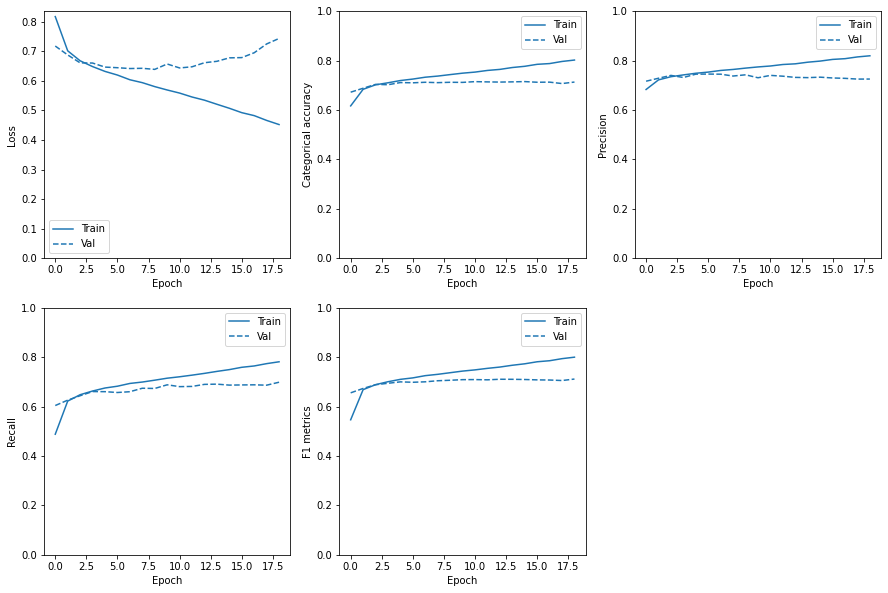

In [116]:
lstm_1 = lstm_1(200)
train_predictions_lstm.append(lstm_1.predict_classes([X_train], batch_size=1024, verbose=2))
test_predictions_lstm.append(lstm_1.predict_classes([X_dev], batch_size=1024, verbose=2))

In [128]:
def lstm_2(lstm_out):
  lstm_model_2 = Sequential()
  lstm_model_2.add(Embedding(input_dim=voc_size, output_dim=embedding_dim, weights = [embedding_matrix] ,input_length=sequence_length))
  lstm_model_2.add(Bidirectional(layers.LSTM(units=lstm_out, dropout=0.2, recurrent_dropout=0.2)))
  lstm_model_2.add(Dropout(0.2))
  lstm_model_2.add(Dense(125, activation='relu'))
  lstm_model_2.add(Dense(units=3, activation='softmax'))
  lstm_model_2.compile(optimizer='adam',
              loss=keras.losses.CategoricalCrossentropy(),
              metrics=Metrics)
  lstm_model_2.summary()

  filepath = "/content/drive/MyDrive/Colab Notebooks/lstm_2.h5"
  checkpoint = ModelCheckpoint(filepath=filepath, monitor="val_f1_metrics",mode="max",save_best_only = True,verbose=2)
  earlystop = EarlyStopping(monitor = 'val_loss',min_delta = 0, patience = 10, verbose = 1, restore_best_weights = True)
  callbacks = [earlystop,checkpoint] 

  history_lstm_2 = lstm_model_2.fit(x=X_train, y=Y_train_cat, validation_data=(X_dev, Y_dev_cat), callbacks=callbacks,batch_size=1028, epochs=20, verbose=2)
  plot_metrics(history_lstm_2)
  scores_2 = lstm_model_2.evaluate(X_dev, Y_dev_cat, verbose=0)
  print("%s: %.2f%%" % (lstm_model_2.metrics_names[1], scores_2[1]*100))
  return lstm_model_2

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_8 (Embedding)      (None, 52, 200)           14691400  
_________________________________________________________________
bidirectional_2 (Bidirection (None, 512)               935936    
_________________________________________________________________
dropout_11 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_19 (Dense)             (None, 125)               64125     
_________________________________________________________________
dense_20 (Dense)             (None, 3)                 378       
Total params: 15,691,839
Trainable params: 15,691,839
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
95/95 - 62s - loss: 0.8121 - categorical_accuracy: 0.6172 - precision: 0.6875 - recall: 0.4909 - 

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


95/95 - 7s
17/17 - 1s


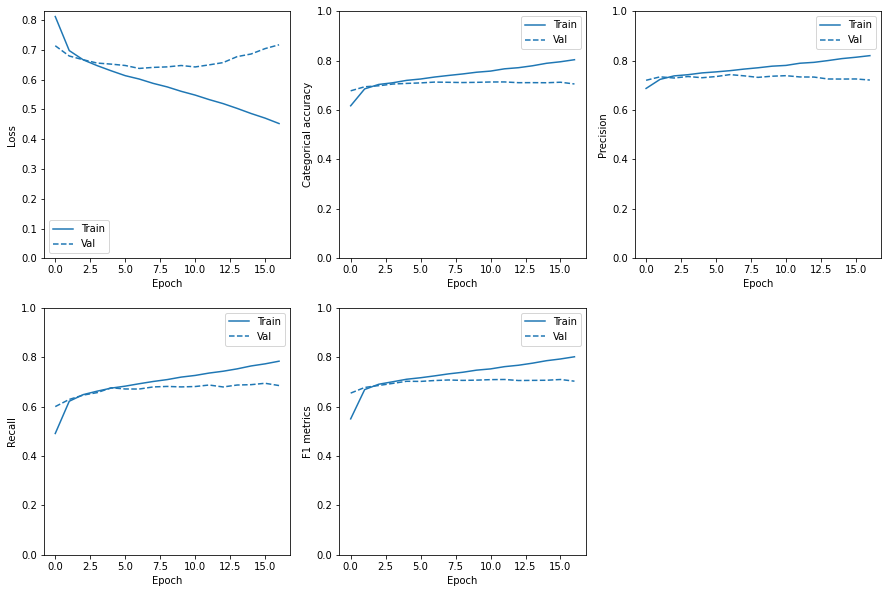

In [129]:
lstm_2 = lstm_2(256)
train_predictions_lstm.append(lstm_2.predict_classes([X_train], batch_size=1024, verbose=2))
test_predictions_lstm.append(lstm_2.predict_classes([X_dev], batch_size=1024, verbose=2))

In [134]:
def lstm_3(lstm_out):
  lstm_model_3 = Sequential()
  lstm_model_3.add(Embedding(input_dim=voc_size, output_dim=embedding_dim, weights = [embedding_matrix] ,input_length=sequence_length))
  lstm_model_3.add(Bidirectional(layers.LSTM(units=lstm_out, dropout=0.2, recurrent_dropout=0.2)))
  lstm_model_3.add(Dropout(0.2))
  lstm_model_3.add(Dense(125, activation='relu'))
  lstm_model_3.add(Dense(units=3, activation='softmax'))
  lstm_model_3.compile(optimizer='adam',
              loss=keras.losses.CategoricalCrossentropy(),
              metrics=Metrics)
  lstm_model_3.summary()

  filepath = "/content/drive/MyDrive/Colab Notebooks/lstm_3.h5"
  checkpoint = ModelCheckpoint(filepath=filepath, monitor="val_f1_metrics",mode="max",save_best_only = True,verbose=2)
  earlystop = EarlyStopping(monitor = 'val_loss',min_delta = 0, patience = 10, verbose = 1, restore_best_weights = True)
  callbacks = [earlystop,checkpoint] 

  history_lstm_3 = lstm_model_3.fit(x=X_train, y=Y_train_cat, validation_data=(X_dev, Y_dev_cat), callbacks=callbacks,batch_size=1028, epochs=20, verbose=2)
  plot_metrics(history_lstm_3)
  scores_3 = lstm_model_3.evaluate(X_dev, Y_dev_cat, verbose=0)
  print("%s: %.2f%%" % (lstm_model_3.metrics_names[1], scores_3[1]*100))
  return lstm_model_3

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_9 (Embedding)      (None, 52, 200)           14691400  
_________________________________________________________________
bidirectional_3 (Bidirection (None, 704)               1557248   
_________________________________________________________________
dropout_12 (Dropout)         (None, 704)               0         
_________________________________________________________________
dense_21 (Dense)             (None, 125)               88125     
_________________________________________________________________
dense_22 (Dense)             (None, 3)                 378       
Total params: 16,337,151
Trainable params: 16,337,151
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
95/95 - 68s - loss: 0.8148 - categorical_accuracy: 0.6168 - precision: 0.6834 - recall: 0.4875 - 

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


95/95 - 10s
17/17 - 2s


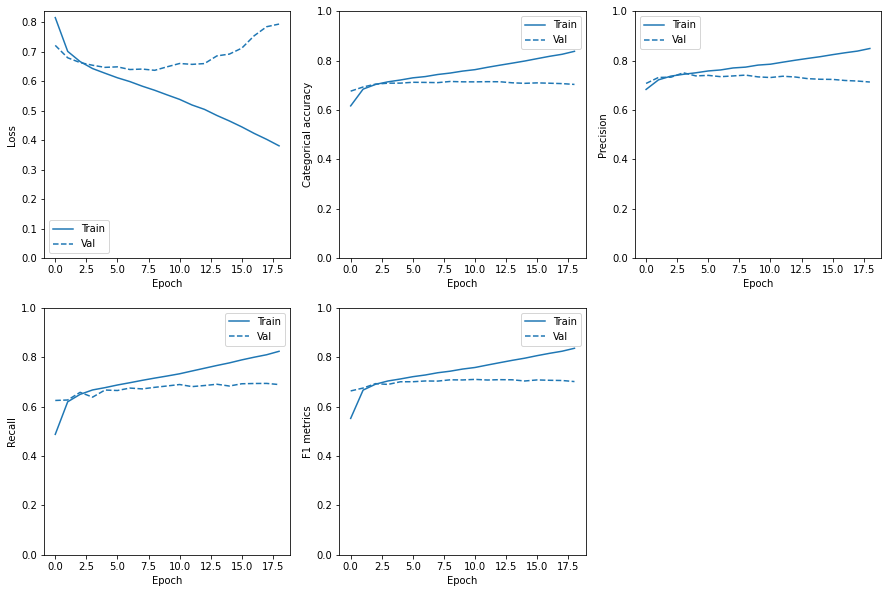

In [135]:
lstm_3 = lstm_3(352)
train_predictions_lstm.append(lstm_3.predict_classes([X_train], batch_size=1024, verbose=2))
test_predictions_lstm.append(lstm_3.predict_classes([X_dev], batch_size=1024, verbose=2))

In [140]:
def lstm_4(lstm_out):
  lstm_model_4 = Sequential()
  lstm_model_4.add(Embedding(input_dim=voc_size, output_dim=embedding_dim, weights = [embedding_matrix] ,input_length=sequence_length))
  lstm_model_4.add(Bidirectional(layers.LSTM(units=lstm_out, dropout=0.2, recurrent_dropout=0.2)))
  lstm_model_4.add(Dropout(0.2))
  lstm_model_4.add(Dense(125, activation='relu'))
  lstm_model_4.add(Dense(units=3, activation='softmax'))
  lstm_model_4.compile(optimizer='adam',
              loss=keras.losses.CategoricalCrossentropy(),
              metrics=Metrics)
  lstm_model_4.summary()

  filepath = "/content/drive/MyDrive/Colab Notebooks/lstm_4.h5"
  checkpoint = ModelCheckpoint(filepath=filepath, monitor="val_f1_metrics",mode="max",save_best_only = True,verbose=2)
  earlystop = EarlyStopping(monitor = 'val_loss',min_delta = 0, patience = 10, verbose = 1, restore_best_weights = True)
  callbacks = [earlystop,checkpoint] 

  history_lstm_4 = lstm_model_4.fit(x=X_train, y=Y_train_cat, validation_data=(X_dev, Y_dev_cat), callbacks=callbacks,batch_size=1028, epochs=20, verbose=2)
  plot_metrics(history_lstm_4)
  scores_4 = lstm_model_4.evaluate(X_dev, Y_dev_cat, verbose=0)
  print("%s: %.2f%%" % (lstm_model_4.metrics_names[1], scores_4[1]*100))
  return lstm_model_4

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_10 (Embedding)     (None, 52, 200)           14691400  
_________________________________________________________________
bidirectional_4 (Bidirection (None, 912)               2396736   
_________________________________________________________________
dropout_13 (Dropout)         (None, 912)               0         
_________________________________________________________________
dense_23 (Dense)             (None, 125)               114125    
_________________________________________________________________
dense_24 (Dense)             (None, 3)                 378       
Total params: 17,202,639
Trainable params: 17,202,639
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
95/95 - 72s - loss: 0.8053 - categorical_accuracy: 0.6243 - precision: 0.6882 - recall: 0.5064 -

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


95/95 - 13s
17/17 - 2s


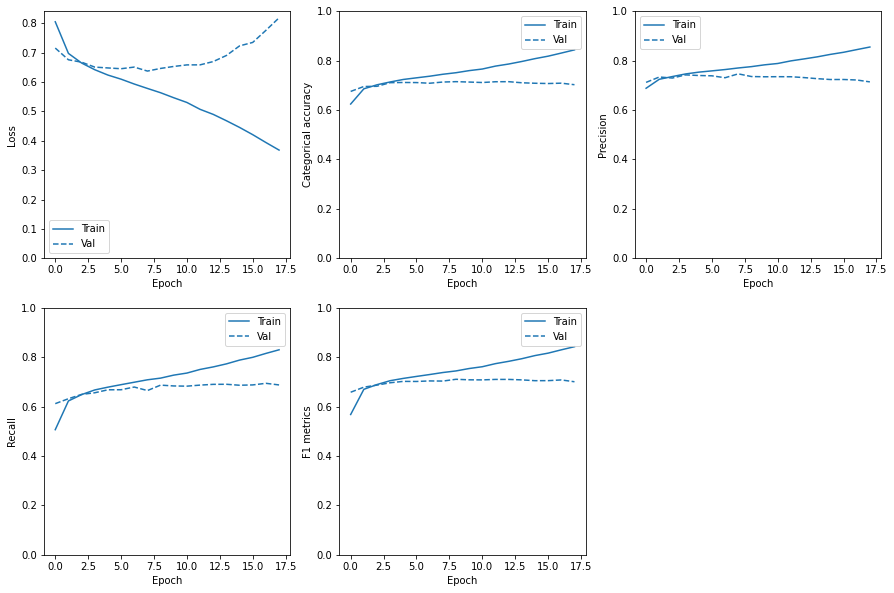

In [141]:
lstm_4 = lstm_4(456)
train_predictions_lstm.append(lstm_4.predict_classes([X_train], batch_size=1024, verbose=2))
test_predictions_lstm.append(lstm_4.predict_classes([X_dev], batch_size=1024, verbose=2))

In [146]:
def lstm_5(lstm_out):
  lstm_model_5 = Sequential()
  lstm_model_5.add(Embedding(input_dim=voc_size, output_dim=embedding_dim, weights = [embedding_matrix] ,input_length=sequence_length))
  lstm_model_5.add(Bidirectional(layers.LSTM(units=lstm_out, dropout=0.2, recurrent_dropout=0.2)))
  lstm_model_5.add(Dropout(0.2))
  lstm_model_5.add(Dense(125, activation='relu'))
  lstm_model_5.add(Dense(units=3, activation='softmax'))
  lstm_model_5.compile(optimizer='adam',
              loss=keras.losses.CategoricalCrossentropy(),
              metrics=Metrics)
  lstm_model_5.summary()

  filepath = "/content/drive/MyDrive/Colab Notebooks/lstm_5.h5"
  checkpoint = ModelCheckpoint(filepath=filepath, monitor="val_f1_metrics",mode="max",save_best_only = True,verbose=2)
  earlystop = EarlyStopping(monitor = 'val_loss',min_delta = 0, patience = 10, verbose = 1, restore_best_weights = True)
  callbacks = [earlystop,checkpoint] 

  history_lstm_5 = lstm_model_5.fit(x=X_train, y=Y_train_cat, validation_data=(X_dev, Y_dev_cat), callbacks=callbacks,batch_size=1028, epochs=20, verbose=2)
  plot_metrics(history_lstm_5)
  scores_5 = lstm_model_5.evaluate(X_dev, Y_dev_cat, verbose=0)
  print("%s: %.2f%%" % (lstm_model_5.metrics_names[1], scores_5[1]*100))
  return lstm_model_5

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_11 (Embedding)     (None, 52, 200)           14691400  
_________________________________________________________________
bidirectional_5 (Bidirection (None, 1064)              3119648   
_________________________________________________________________
dropout_14 (Dropout)         (None, 1064)              0         
_________________________________________________________________
dense_25 (Dense)             (None, 125)               133125    
_________________________________________________________________
dense_26 (Dense)             (None, 3)                 378       
Total params: 17,944,551
Trainable params: 17,944,551
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
95/95 - 84s - loss: 0.8091 - categorical_accuracy: 0.6220 - precision: 0.6866 - recall: 0.4986 -

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


95/95 - 16s
17/17 - 3s


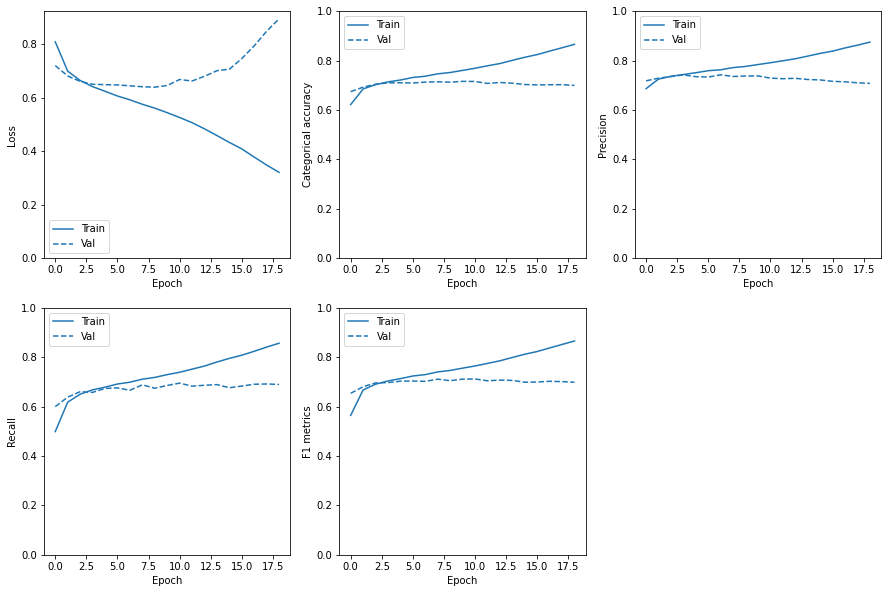

In [147]:
lstm_5 = lstm_5(532)
train_predictions_lstm.append(lstm_5.predict_classes([X_train], batch_size=1024, verbose=2))
test_predictions_lstm.append(lstm_5.predict_classes([X_dev], batch_size=1024, verbose=2))

In [152]:
w = np.array(list(zip(*np.squeeze(test_predictions_lstm))))
w.shape

(17133, 6)

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, 6)]               0         
_________________________________________________________________
dropout_15 (Dropout)         (None, 6)                 0         
_________________________________________________________________
dense_27 (Dense)             (None, 7776)              54432     
_________________________________________________________________
dropout_16 (Dropout)         (None, 7776)              0         
_________________________________________________________________
dense_28 (Dense)             (None, 240)               1866480   
_________________________________________________________________
batch_normalization_1 (Batch (None, 240)               960       
_________________________________________________________________
dropout_17 (Dropout)         (None, 240)               0   

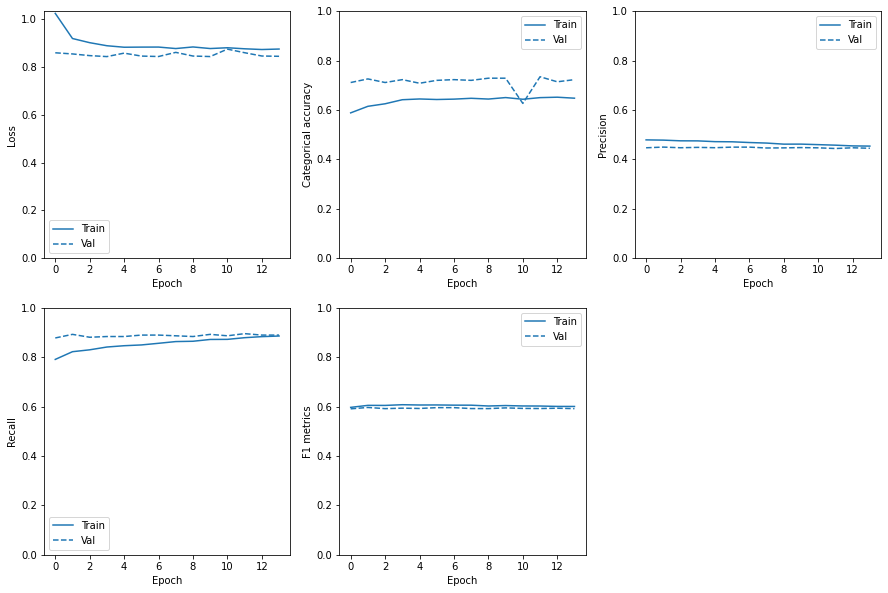

In [153]:
from keras.layers import BatchNormalization
def lstm_stack_models(predictions, targets):
    layer_size = len(predictions)
    inp = Input(shape=(layer_size,))
    d0 = Dropout(0.2)(inp)
    d0 = Dense(pow(layer_size, 5))(d0)
    d1 = Dropout(0.2)(d0)
    d1 = Dense(40 * layer_size)(d1)
    b = BatchNormalization()(d1)
    out = Dropout(0.2)(b)
    out = Dense(3, activation='sigmoid')(out)

    all_lstm_model = Model(inputs=inp, outputs=out)
    all_lstm_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=Metrics)
    all_lstm_model.summary()

    x = np.array(list(zip(*np.squeeze(predictions))))
    y = targets
    print(np.shape(x))
    print(np.shape(y))
    filepath = "/content/drive/MyDrive/Colab Notebooks/stacked_lstm_models.h5"
    checkpoint = ModelCheckpoint(filepath=filepath, monitor="val_f1_metrics",mode="max",save_best_only = True,verbose=2)
    earlystop = EarlyStopping(monitor = 'val_loss',min_delta = 0, patience = 10, verbose = 1, restore_best_weights = True)
    callbacks = [earlystop,checkpoint] 
    
    all_lstm_history = all_lstm_model.fit(x=x, y=y, epochs=50, validation_split=0.02, callbacks=callbacks,verbose=2)
    plot_metrics(all_lstm_history)
    return all_lstm_model
    
stacked_lstm_model = lstm_stack_models(test_predictions_lstm, Y_dev_cat)

lstm_stacked_test_predictions = np.array(list(zip(*np.squeeze(test_predictions_lstm))))
lstm_stacked_test_predictions = stacked_lstm_model.predict(lstm_stacked_test_predictions, batch_size=1024)

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        [(None, 11)]              0         
_________________________________________________________________
dropout_21 (Dropout)         (None, 11)                0         
_________________________________________________________________
dense_33 (Dense)             (None, 161051)            1932612   
_________________________________________________________________
dropout_22 (Dropout)         (None, 161051)            0         
_________________________________________________________________
dense_34 (Dense)             (None, 440)               70862880  
_________________________________________________________________
batch_normalization_3 (Batch (None, 440)               1760      
_________________________________________________________________
dropout_23 (Dropout)         (None, 440)               0   

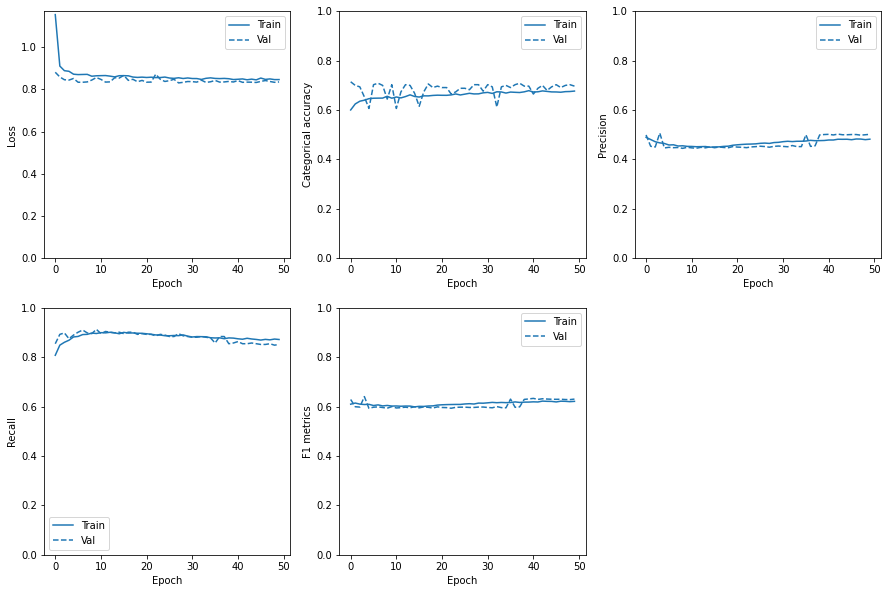

In [159]:
total_train_predictions = train_predictions + train_predictions_lstm
total_test_predictions = test_predictions + test_predictions_lstm


def total_stack_models(predictions, targets):
    layer_size = len(predictions)
    inp = Input(shape=(layer_size,))
    d0 = Dropout(0.2)(inp)
    d0 = Dense(pow(layer_size, 5))(d0)
    d1 = Dropout(0.2)(d0)
    d1 = Dense(40 * layer_size)(d1)
    b = BatchNormalization()(d1)
    out = Dropout(0.2)(b)
    out = Dense(3, activation='sigmoid')(out)

    all_model = Model(inputs=inp, outputs=out)
    all_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=Metrics)
    all_model.summary()


    x = np.array(list(zip(*np.squeeze(predictions))))
    y = targets
    print(np.shape(x))
    print(np.shape(y))
    
    filepath = "/content/drive/MyDrive/Colab Notebooks/cnn_lstm_stacked.h5"
    checkpoint = ModelCheckpoint(filepath=filepath, monitor="val_f1_metrics",mode="max",save_best_only = True,verbose=2)
    earlystop = EarlyStopping(monitor = 'val_loss',min_delta = 0, patience = 10, verbose = 1, restore_best_weights = True)
    callbacks = [earlystop,checkpoint]

    total_history = all_model.fit(x=x, y=y, epochs=50, validation_split=0.02, verbose=2, shuffle=True)
    plot_metrics(total_history)
    return all_model
    
all_stacked_models = total_stack_models(total_test_predictions, Y_dev_cat)

total_stacked_test_predictions = np.array(list(zip(*np.squeeze(total_test_predictions))))
total_stacked_test_predictions = all_stacked_models.predict(total_stacked_test_predictions, batch_size=1024)